In [1]:
#!pip install tensorflow

In [2]:
#!pip install xgboost

In [3]:
#!pip install keras

In [4]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
raw_df = pd.read_csv('listings.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (43,61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The dataset contains 49530 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200608144437,2020-06-09,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/3755/3f9d3...,NaN,2259,https://www.airbnb.com/users/show/2259,Jenny,2008-08-18,US,NaN,a few days or more,0%,50%,f,https://a0.muscache.com/im/users/2259/profile_...,https://a0.muscache.com/im/users/2259/profile_...,Washington Heights,0.0,0.0,['reviews'],t,f,"New York, NY, United States",Washington Heights,Washington Heights,Manhattan,New York,NY,10040,New York,"New York, NY",US,United States,40.85722,-73.93790,t,Other,Private room,2,NaN,1.0,2.0,Real Bed,"{Internet,Wifi}",NaN,$100.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,4 months ago,t,30,60,90,365,2020-06-09,1,0,2008-09-22,2008-09-22,80.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200608144437,2020-06-09,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,84%,37%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, NY, United States",Manhattan,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",NaN,$225.00,"$1,995.00",NaN,$350.00,$95.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,3 months ago,t,3,30,60,335,2020-06-09,48,3,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10

In [6]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

In [7]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                          6
host_response_time                              27316
host_response_rate                              27316
host_acceptance_rate                            15396
host_is_superhost                                   6
host_listings_count                                 6
host_total_listings_count                           6
host_has_profile_pic                                6
host_identity_verified                              6
street                                              0
neighbourhood                                      11
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                              142
state                                               5
zipcode                                           429
market                      

In [8]:

df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

In [9]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

6


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4446862,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Crown Heights,Crown Heights,Brooklyn,NY,11238,New York,"Brooklyn, NY",US,United States,40.67512,-73.96146,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",$50.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,61 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,NaN
4763327,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Greenpoint,Greenpoint,Brooklyn,NY,11211,New York,"Brooklyn, NY",US,United States,40.72035,-73.95355,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$195.00,$295.00,$70.00,2,$25.00,1,1125,1,1,1125,1125,1.0,1125.0,56 months ago,t,0,0,0,0,1,0,2015-10-20,2015-10-20,80.0,8.0,10.0,10.0,8.0,10.0,8.0,f,f,f,moderate,f,f,1,1,0,0,0.02
6360224,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Brooklyn,Bushwick,Brooklyn,NY,11206,New York,"Brooklyn, NY",US,United States,40.70146,-73.92792,t,Apartment,Private room,1,0.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Buz...",$37.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,60 months ago,t,0,0,0,0,1,0,2015-07-01,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,0.02
6992973,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",Brooklyn,Williamsburg,Brooklyn,NY,11249,New York,"Brooklyn, NY",US,United States,40.71838,-73.95630,t,Apartment,Entire home/apt,4,2.0,2.0,1.0,Real Bed,"{""Air conditioning"",Kitchen,""Pets allowed"",""Bu...",$145.00,"$1,000.00",$75.00,2,$50.00,1,1125,1,1,1125,1125,1.0,1125.0,60 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,1,0,0,NaN
7556587,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, NY, United States",Hamilton Heights,Harlem,New York,NY,10032,New York,"New York, NY",US,United States,40.82929,-73.94182,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Wheelchair accessible"",Kitchen...",$28.00,NaN,NaN,1,$10.00,1,1125,1,1,1125,1125,1.0,1125.0,59 months ago,t,0,0,0,0,1,0,2015-08-01,2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,0.02


In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [11]:
lat_long = df[['latitude', 'longitude']]

In [12]:

df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [13]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)


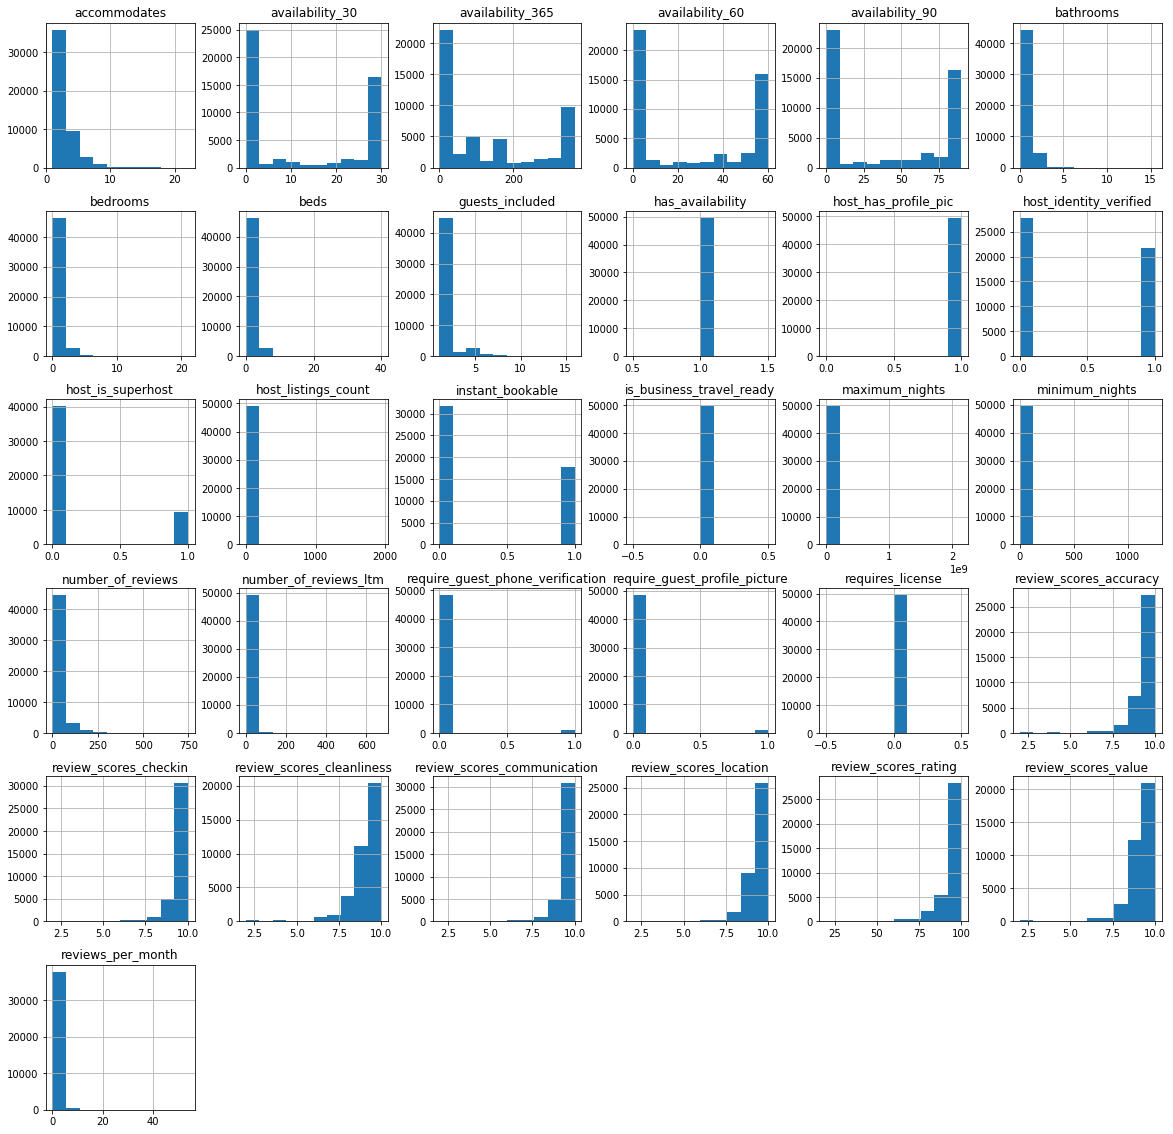

In [14]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [15]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

## Cleaning Individual Columns

In [16]:
df.experiences_offered.value_counts()


none    49530
Name: experiences_offered, dtype: int64

In [17]:
df.drop('experiences_offered', axis=1, inplace=True)

In [18]:
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1334.0
Median days as host: 1365.0


In [19]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 27316
Proportion: 55.2%


In [20]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.551504
within an hour        0.253341
within a few hours    0.099071
within a day          0.069009
a few days or more    0.027075
Name: host_response_time, dtype: float64

In [21]:
df.host_response_time.value_counts(normalize=True)

unknown               0.551504
within an hour        0.253341
within a few hours    0.099071
within a day          0.069009
a few days or more    0.027075
Name: host_response_time, dtype: float64

In [22]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 27316
Proportion: 55.2%


In [23]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 90.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.5%


In [24]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    27316
100%       15669
50-89%      3542
0-49%       1792
90-99%      1211
Name: host_response_rate, dtype: int64

In [25]:
# Number of rows without a value for multiple host-related columns
df.dropna(subset=['host_since'], inplace=True)


In [26]:
df.property_type.value_counts()


Apartment                 38488
House                      3932
Townhouse                  1804
Condominium                1752
Loft                       1335
Serviced apartment          486
Boutique hotel              455
Guest suite                 422
Hotel                       308
Other                       103
Guesthouse                   75
Resort                       73
Bed and breakfast            62
Hostel                       45
Aparthotel                   30
Villa                        29
Bungalow                     25
Tiny house                   23
Camper/RV                    17
Boat                          8
Cottage                       7
Earth house                   6
Tent                          5
Barn                          4
Cave                          4
Castle                        3
Houseboat                     3
Dome house                    3
Casa particular (Cuba)        3
Cabin                         2
Lighthouse                    2
Island  

In [27]:

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [28]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [29]:
df.bed_type.value_counts()


Real Bed         48819
Futon              266
Pull-out Sofa      217
Airbed             149
Couch               61
Name: bed_type, dtype: int64

In [30]:
df.drop('bed_type', axis=1, inplace=True)


In [31]:
# Example of amenities listed
df.amenities[:1].values

array(['{Internet,Wifi}'], dtype=object)

In [32]:
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Bar',
 'Barbecue utensils',
 'Bath towel',
 'Bathrobes',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bluetooth speaker',
 'Body soap',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide alarm',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Concierge',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around be

In [33]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [34]:

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'breakfast', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


In [35]:
df.columns[40:]


Index(['air_conditioning', 'bed_linen', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'self_check_in'],
      dtype='object')

In [36]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [37]:
df.security_deposit.isna().sum()


17180

In [38]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

In [39]:
df.cleaning_fee.isna().sum()


10859

In [40]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [41]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [42]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 97

Top five categories:


3 months ago    7269
4 months ago    4340
5 months ago    2814
2 weeks ago     2788
2 months ago    2359
Name: calendar_updated, dtype: int64

In [43]:
df.drop('calendar_updated', axis=1, inplace=True)


In [44]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [45]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 22.9%
Null values in 'review_scores_rating': 24.8%


In [46]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

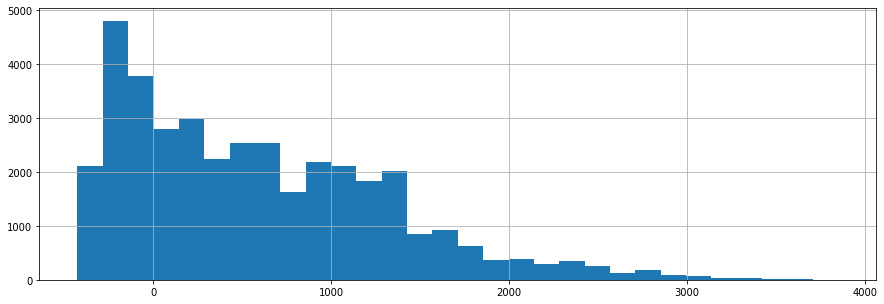

In [47]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [48]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [49]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [50]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

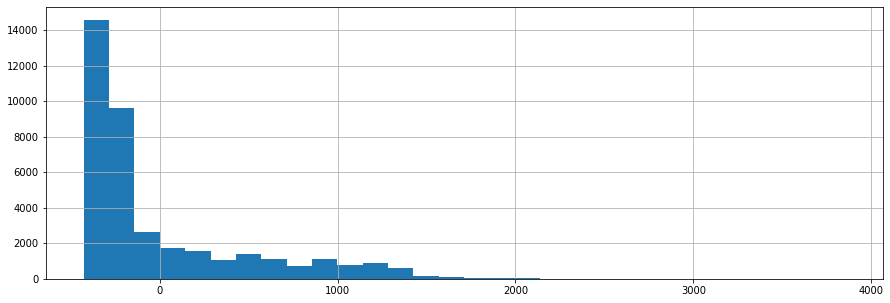

In [51]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [52]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

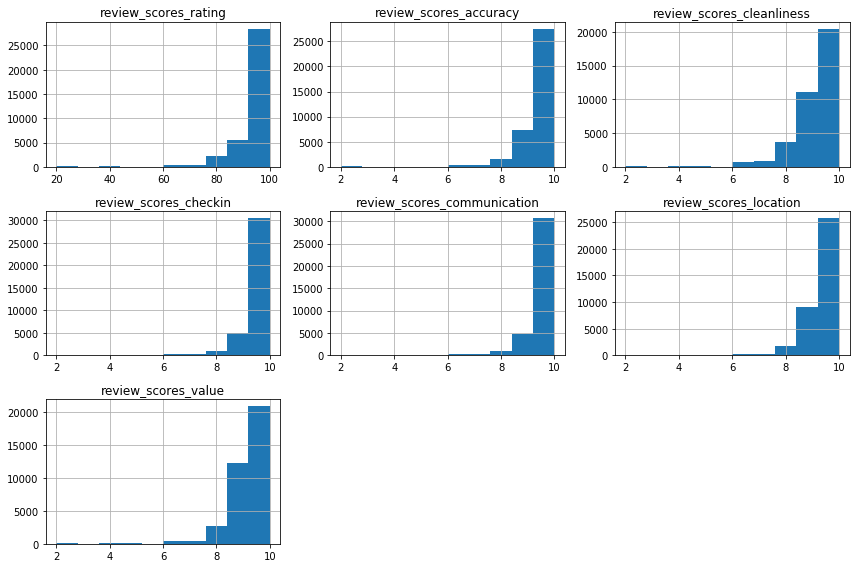

In [53]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [54]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [55]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [56]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [57]:
df.cancellation_policy.value_counts()


strict_14_with_grace_period    21573
flexible                       16505
moderate                       11372
super_strict_60                   58
super_strict_30                   15
strict                             1
Name: cancellation_policy, dtype: int64

In [58]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [59]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [60]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 18 August 2008, and the most recent joined on 07 June 2020.


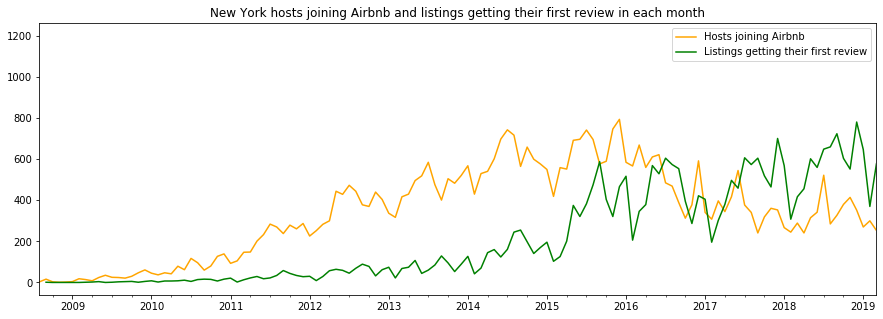

In [61]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('New York hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [62]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [63]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

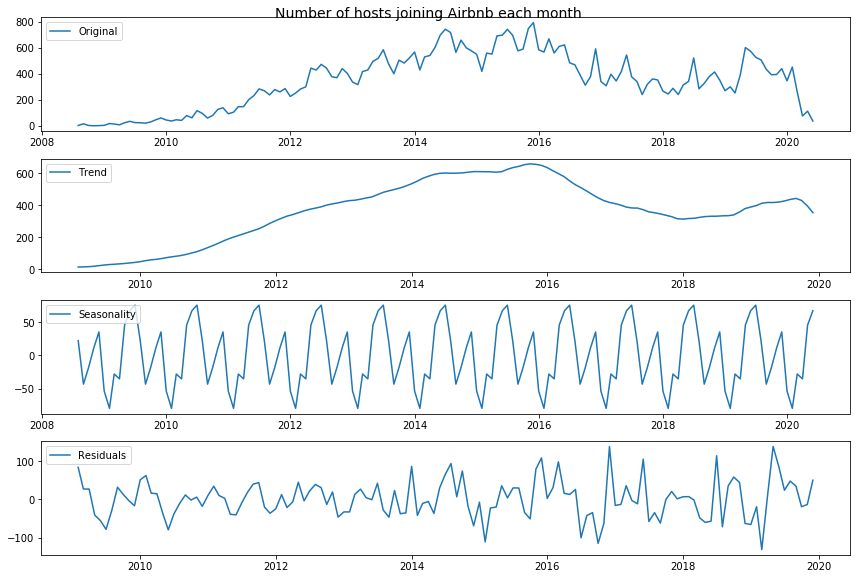

In [64]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

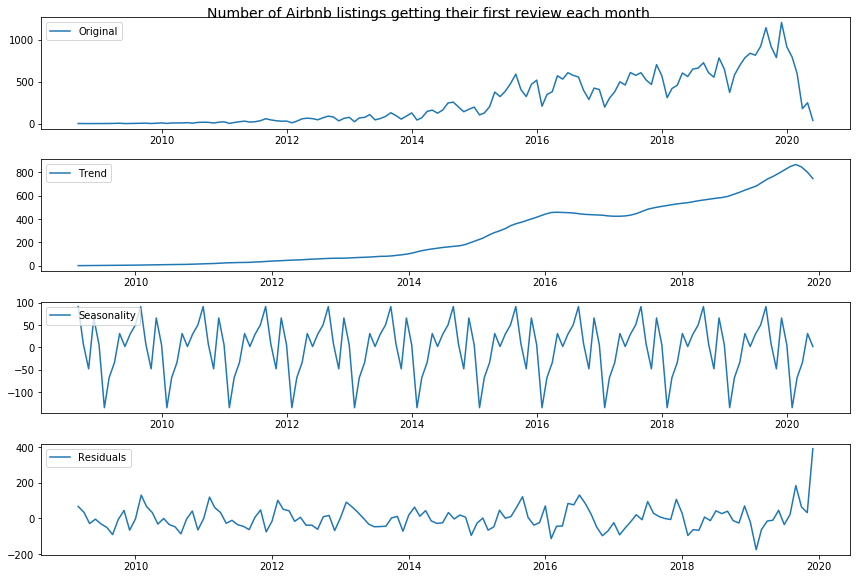

In [65]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],


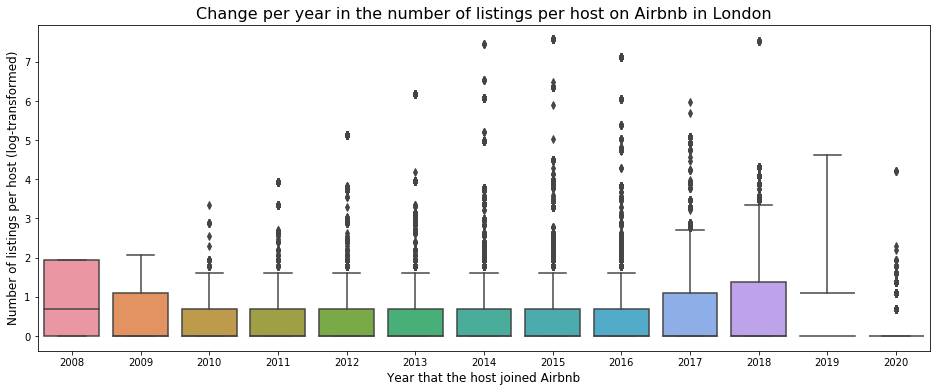

In [66]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

In [67]:
print("Average number of listings per host per year on Airbnb in New York:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in New York:
host_since
2008-01-01     3.52
2009-01-01     1.84
2010-01-01     2.01
2011-01-01     2.99
2012-01-01     3.99
2013-01-01     8.53
2014-01-01     8.31
2015-01-01    34.13
2016-01-01    61.76
2017-01-01    10.48
2018-01-01    13.62
2019-01-01     3.41
2020-01-01     1.15
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [68]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
21996644,2016-09-16,424.0
27659298,2014-02-14,437.0
43106544,2013-10-14,480.0
43475493,2015-03-30,580.0
6117496,2015-04-07,653.0
33216902,2014-12-14,688.0
31038347,2016-12-16,1230.0
41559383,2014-01-03,1717.0
41106442,2018-06-11,1866.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


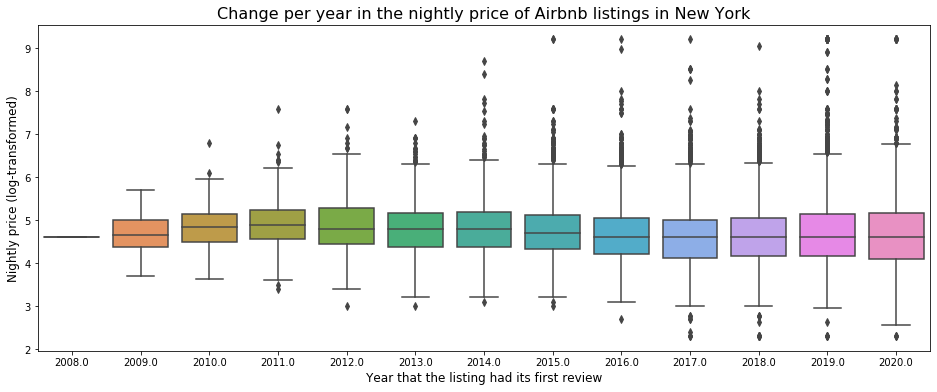

In [69]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in New York', fontsize=16)
plt.show()

In [70]:
print("Mean nightly price of listings in each year on Airbnb in New York:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in New York:
first_review
2008-01-01    100.00
2009-01-01    121.54
2010-01-01    144.97
2011-01-01    162.05
2012-01-01    161.67
2013-01-01    150.30
2014-01-01    156.18
2015-01-01    147.33
2016-01-01    136.74
2017-01-01    129.61
2018-01-01    132.29
2019-01-01    167.21
2020-01-01    188.00
Name: price, dtype: float64


In [71]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [72]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,air_conditioning,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,time_since_last_review
count,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,4.952400e+04,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,49524.000000,38207.000000
mean,0.191483,18.143748,0.439120,2.836483,1.148998,1.186233,1.532489,162.651967,177.614207,54.937969,1.500424,13.598175,8.192149,8.813228e+04,40.051127,23.870225,0.360492,1334.076872,0.847125,0.324045,0.694653,0.342622,0.369861,0.465734,0.256603,0.101809,0.245659,0.432578,0.136035,0.975830,0.201801,0.179489,0.220923,0.203679,-8.068312
std,0.393472,135.457329,0.496285,1.875267,0.435268,0.766625,1.135178,419.336518,442.760528,65.603354,1.154371,23.796802,21.976030,1.364744e+07,40.296561,48.248112,0.480148,919.010497,0.359871,0.468022,0.460559,0.474591,0.482772,0.498829,0.436763,0.302400,0.430481,0.495438,0.342829,0.153579,0.401349,0.383765,0.414873,0.402737,492.445506
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,-425.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-427.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,68.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.900000e+01,0.000000,1.000000,0.000000,650.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-334.000000
50%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,101.000000,0.000000,40.000000,1.000000,0.000000,3.000000,6.000000e+02,30.000000,5.000000,0.000000,1365.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-258.000000
75%,0.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.000000,175.000000,200.000000,80.000000,2.000000,20.000000,6.000000,1.125000e+03,88.000000,23.000000,1.000000,2008.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,154.000000
max,1.000000,1941.000000,1.000000,22.000000,15.500000,21.000000,40.000000,10000.000000,5100.000000,1000.000000,16.000000,300.000000,1250.000000,2.147484e+09,90.000000,746.000000,1.000000,3886.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3851.000000


In [73]:
print(f"Nightly advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Nightly advertised prices range from $0 to $10000.


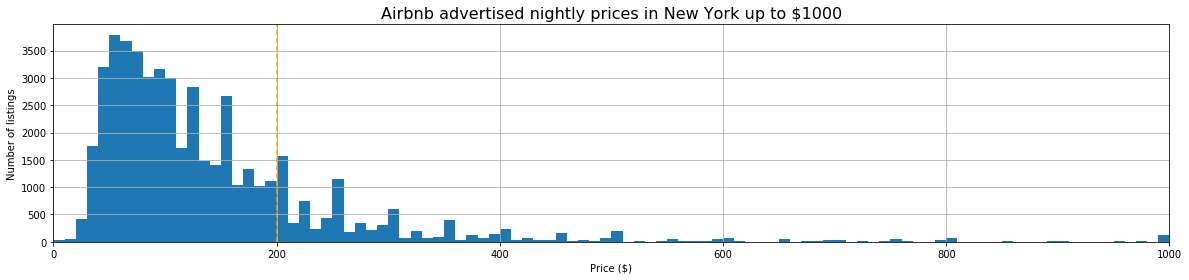

In [74]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in New York up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

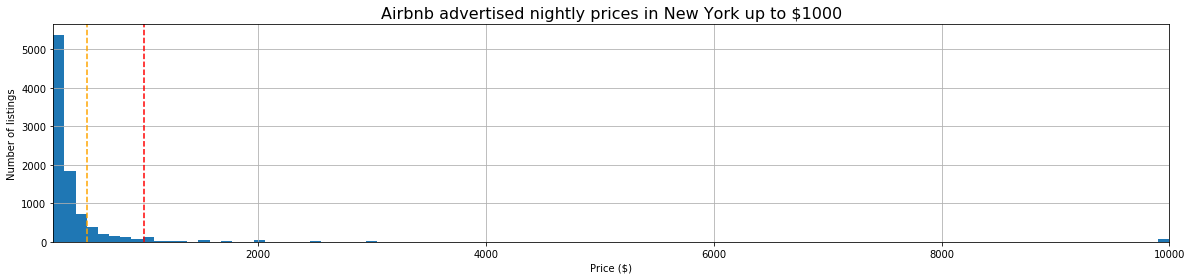

In [75]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in New York up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [76]:
# Replacing values under $10 with $10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
df.loc[df.price >= 1000, 'price'] = 1000

In [77]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 18
54% of listings are from hosts with one listing.


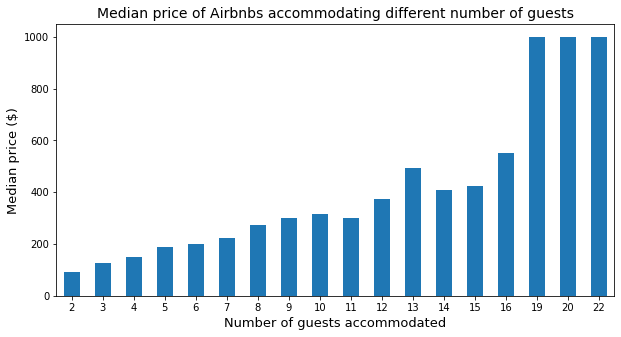

In [78]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

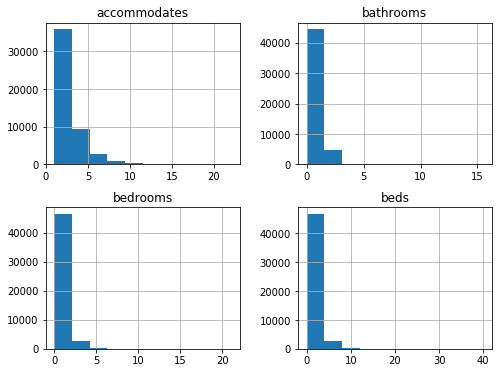

In [79]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));


In [80]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

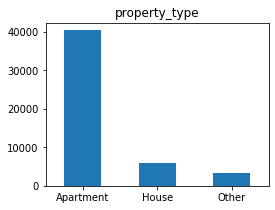

Apartment    0.813929
House        0.117640
Other        0.068431
Name: property_type, dtype: float64


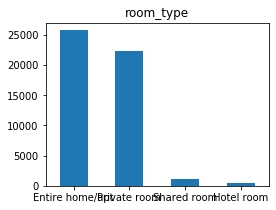

Entire home/apt    0.519203
Private room       0.449802
Shared room        0.022292
Hotel room         0.008703
Name: room_type, dtype: float64


In [81]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

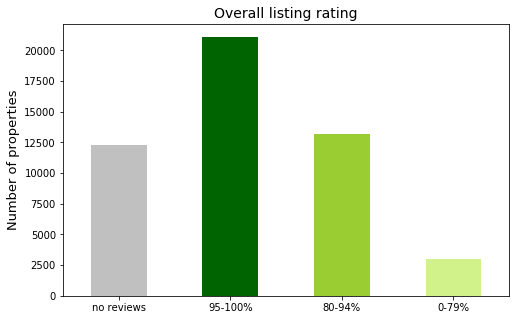

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

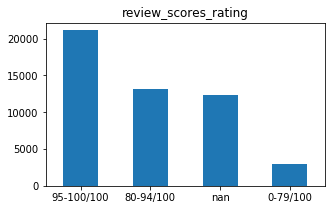

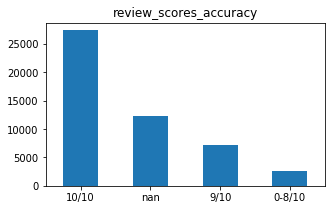

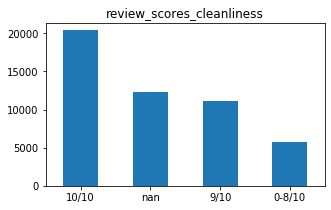

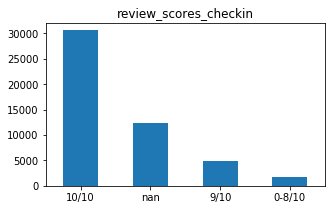

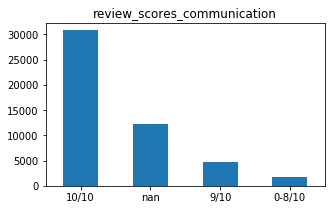

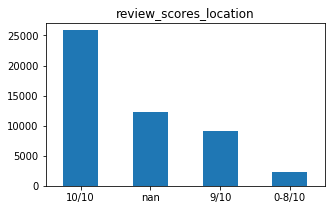

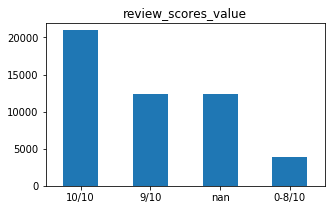

In [83]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

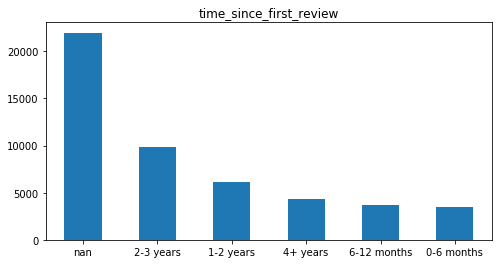

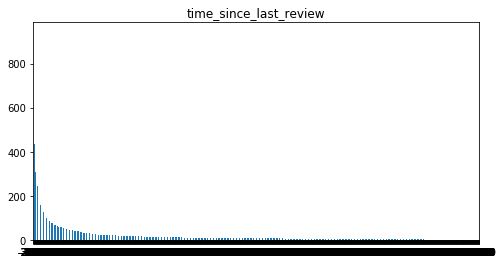

In [84]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

In [85]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()

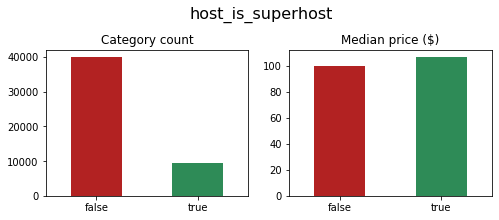

0.0    0.808517
1.0    0.191483
Name: host_is_superhost, dtype: float64


In [86]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

In [87]:
df.host_identity_verified.value_counts(normalize=True)


0.0    0.56088
1.0    0.43912
Name: host_identity_verified, dtype: float64

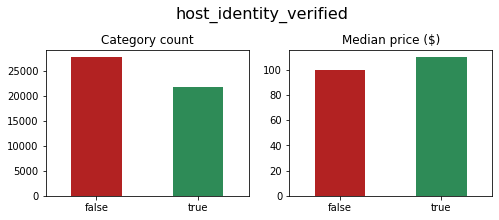

In [88]:
binary_count_and_price_plot('host_identity_verified')


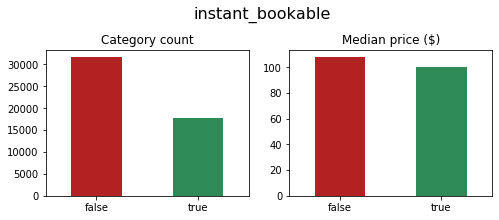

0    0.639508
1    0.360492
Name: instant_bookable, dtype: float64


In [89]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

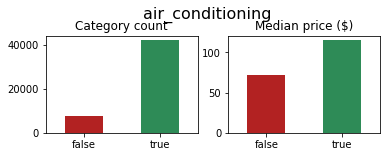

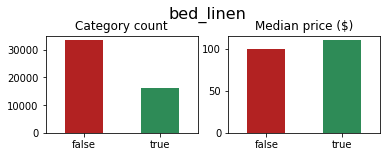

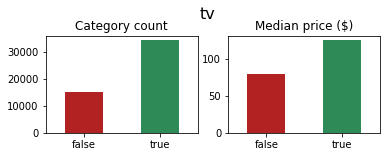

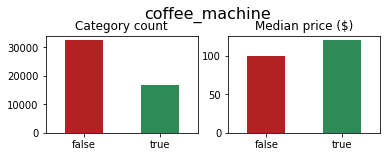

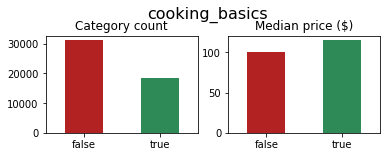

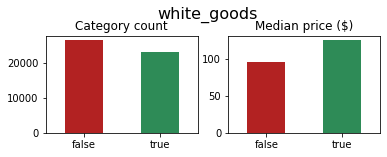

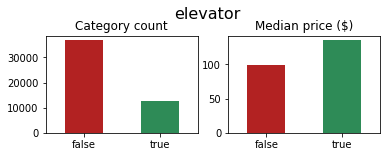

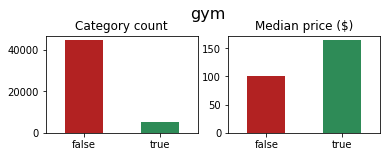

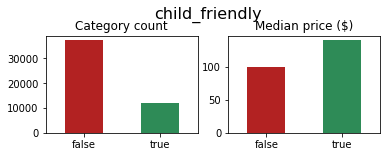

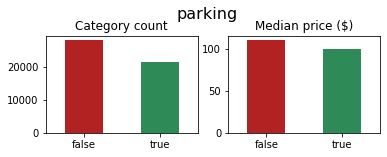

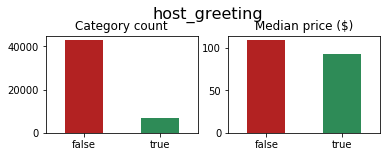

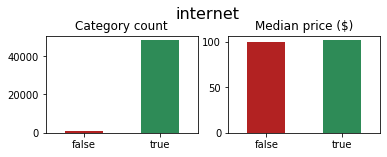

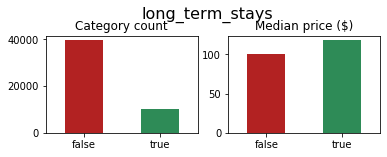

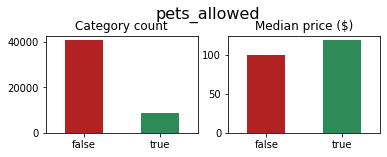

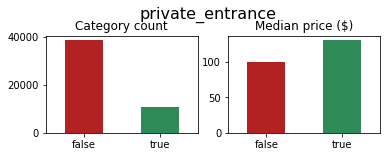

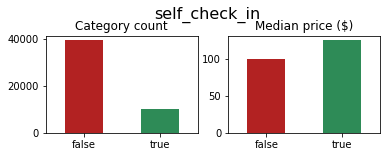

In [90]:
for col in df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

In [91]:
transformed_df = pd.get_dummies(df)


In [92]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

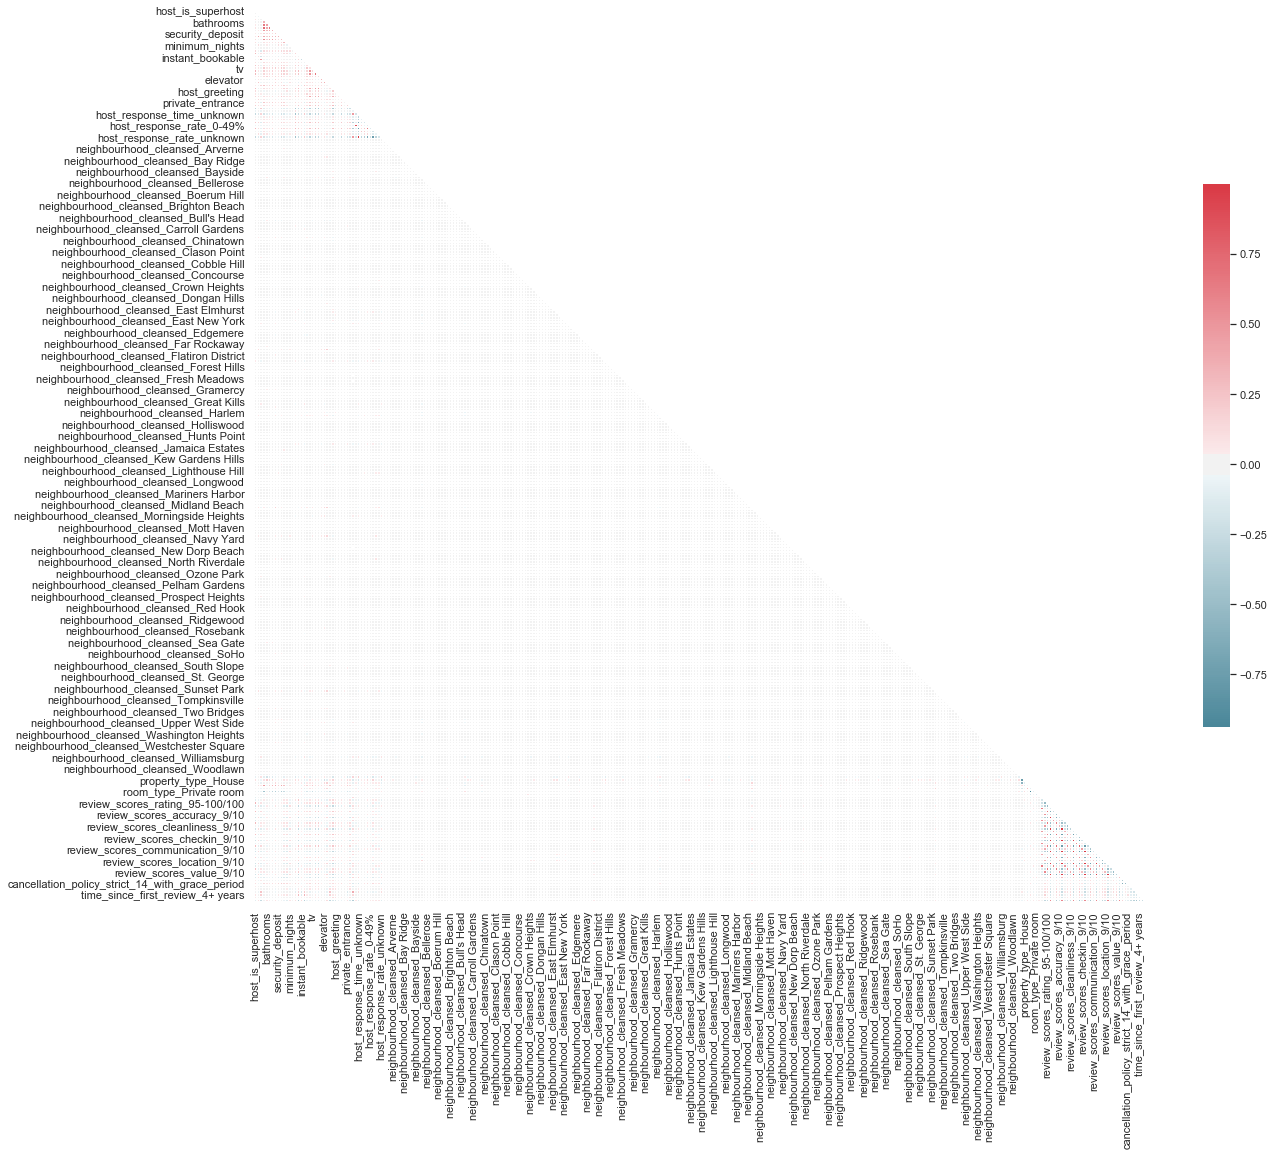

In [93]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

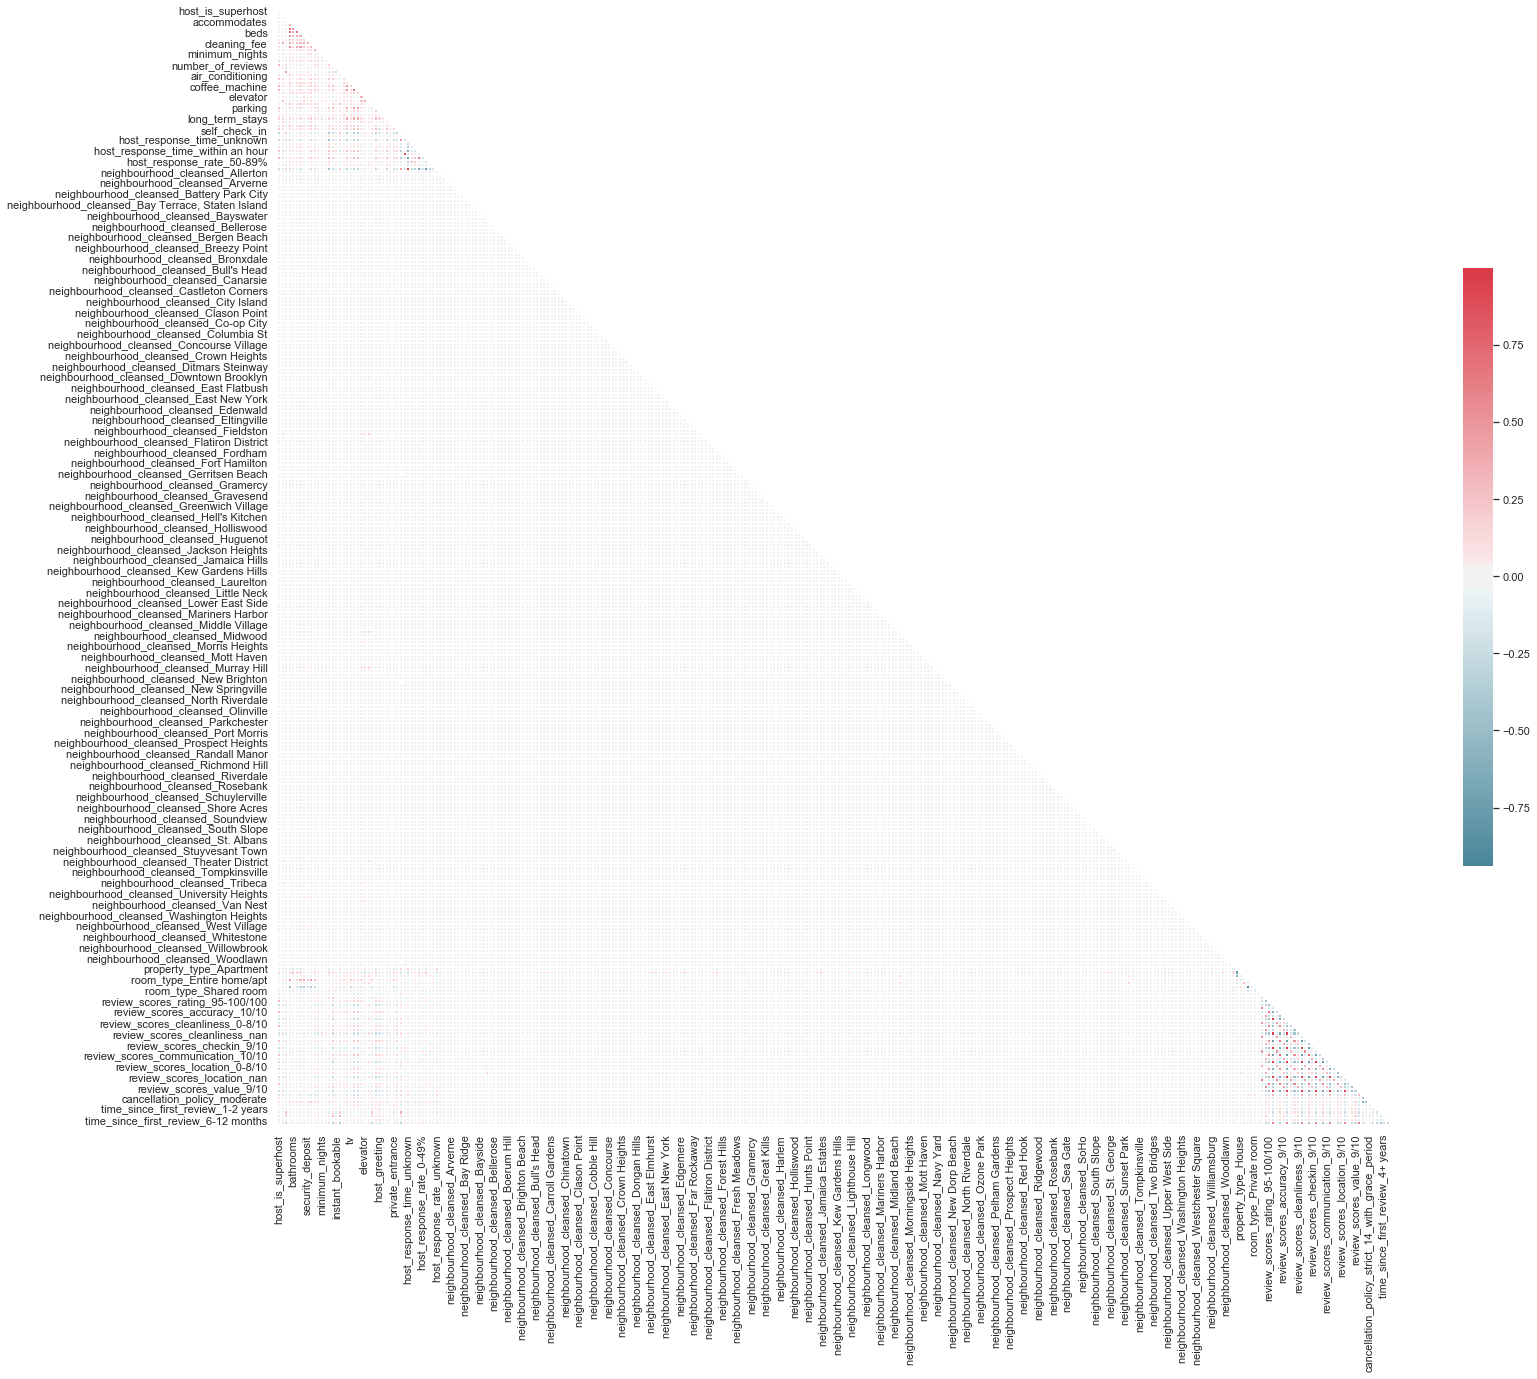

In [94]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [95]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

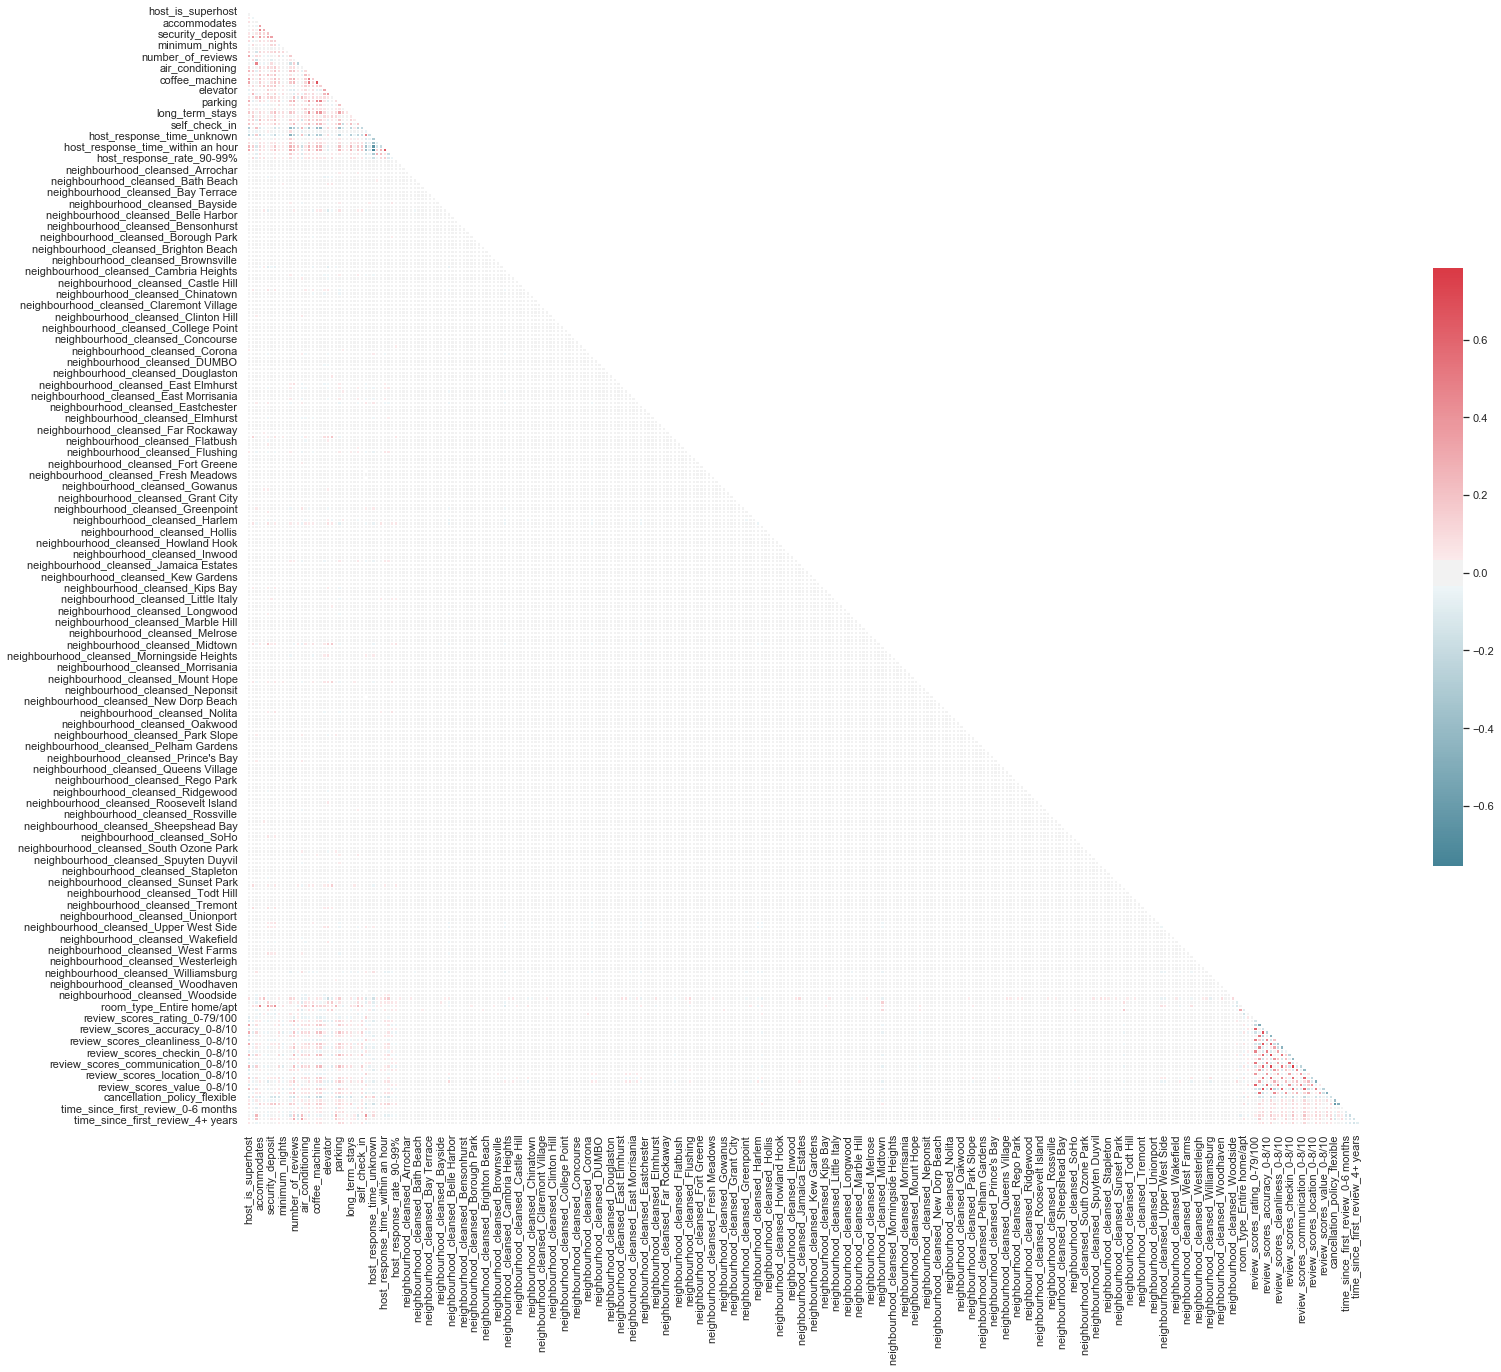

In [96]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [97]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

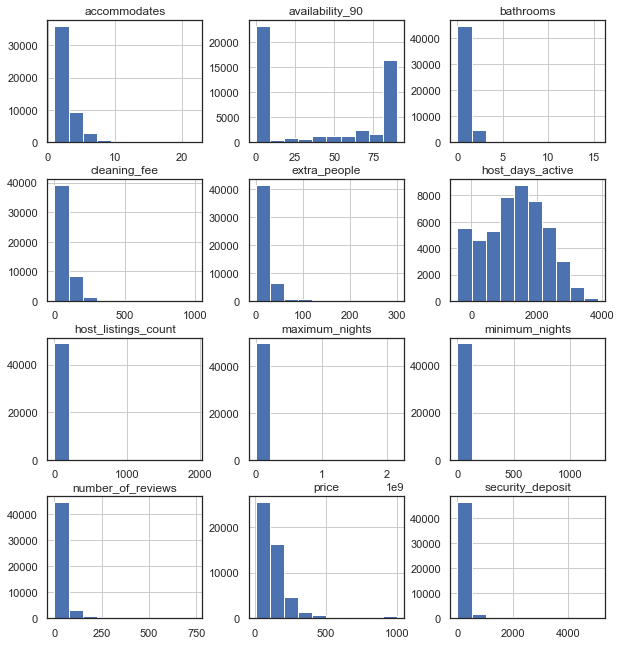

In [98]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [99]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

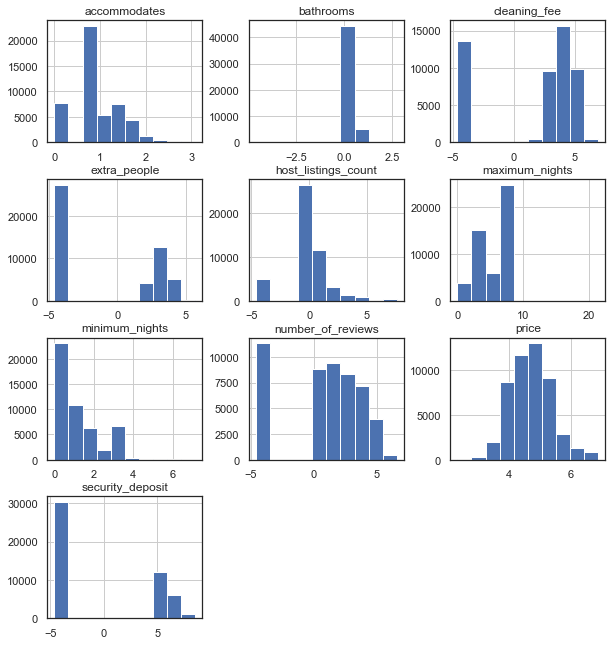

In [100]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [101]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [102]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [103]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.3 minutes

Training MSE: 0.1074
Validation MSE: 0.1466

Training r2: 0.775
Validation r2: 0.6968


In [104]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
neighbourhood_cleansed_Jamaica Hills,0.000000
neighbourhood_cleansed_Holliswood,0.000000
neighbourhood_cleansed_Howland Hook,0.000000
neighbourhood_cleansed_Huguenot,0.000000
neighbourhood_cleansed_Hunts Point,0.000000
...,...
neighbourhood_cleansed_Bushwick,0.019653
property_type_Other,0.028901
bathrooms,0.036188
neighbourhood_cleansed_Midtown,0.039529


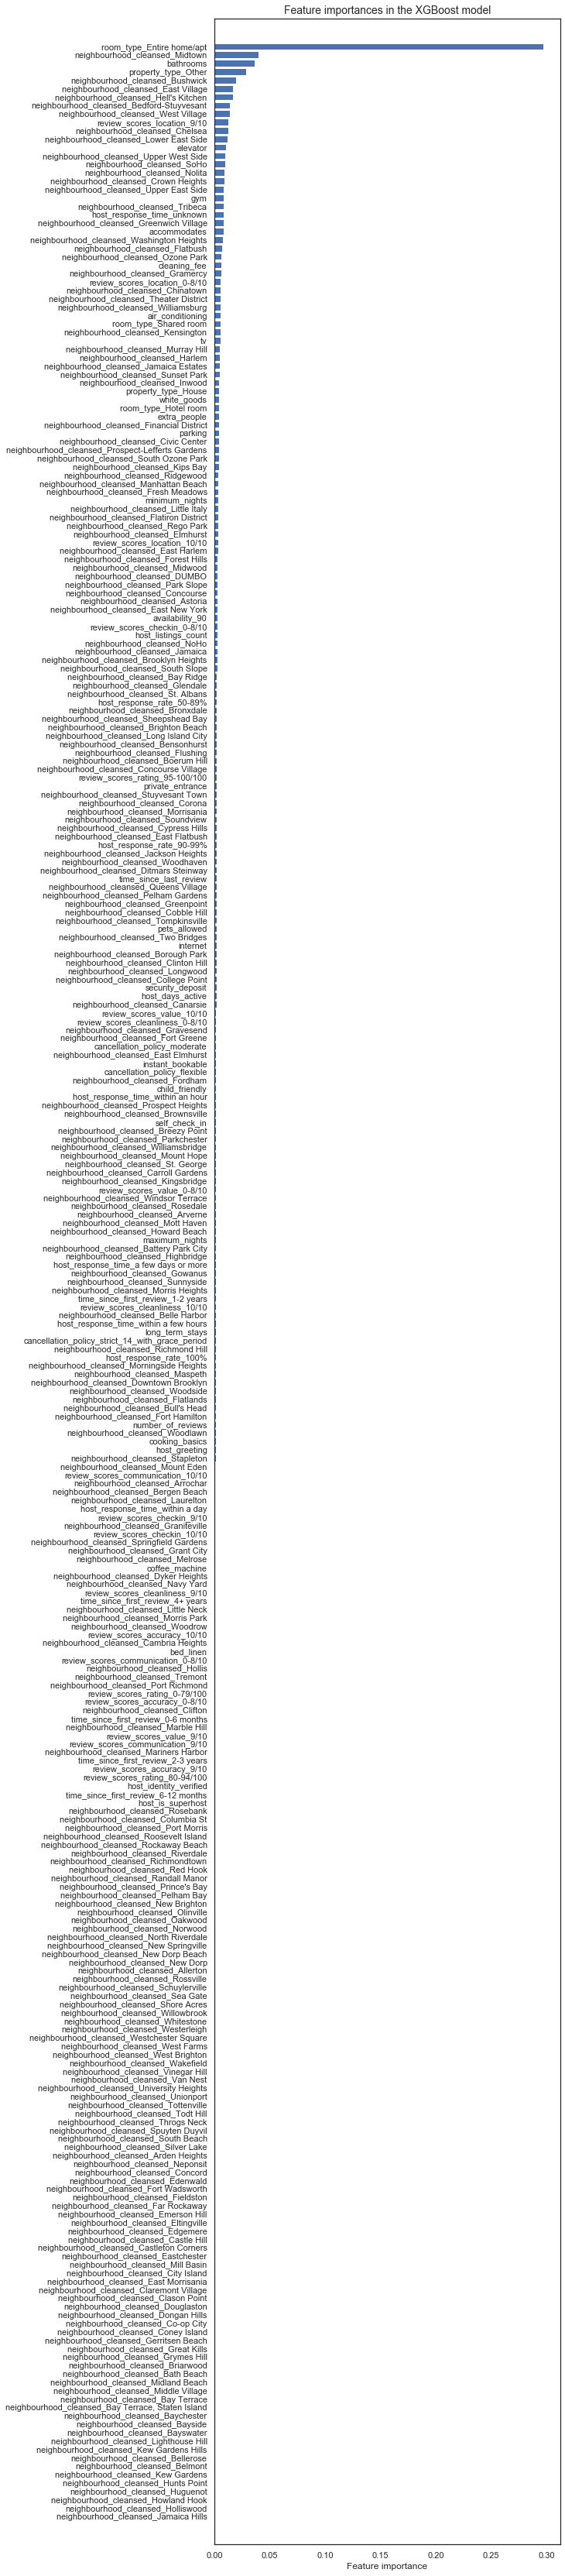

In [105]:
# Plotting feature importances
plt.figure(figsize=(8,60))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

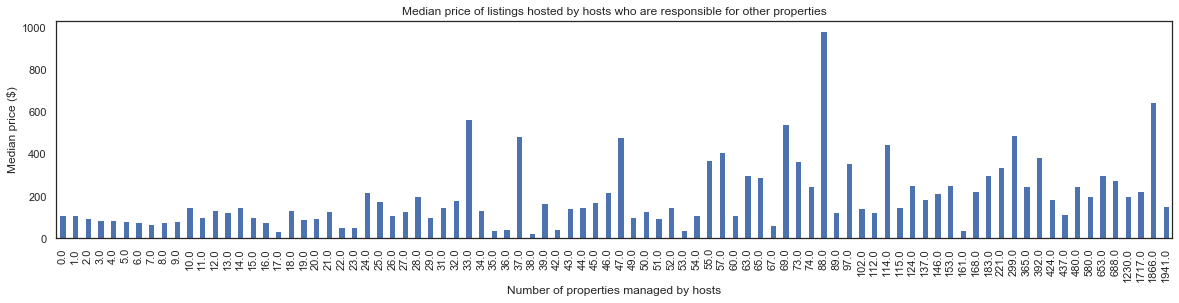

In [106]:
#Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');